In [1]:
%load_ext autoreload
%autoreload 2
from nvidia.dali.plugin.pytorch import DALIGenericIterator
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import optim, nn
from pytorch_metric_learning import losses
from sklearn.metrics import classification_report
from data import (
    get_urls_indexes,
    pipeline,
    benchmark_pipeline,
    get_max_frames,
    num_frames_to_attention_mask,
    EMOTIONS,
)
from utils import log, get_timestamp

In [2]:
model_device = torch.device("cuda:0")
dali_device = model_device.index

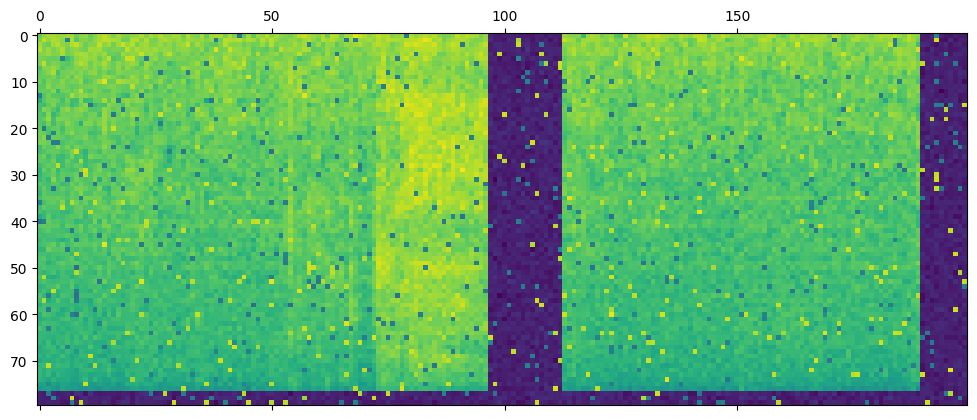

In [3]:
# urls, indexes = get_urls_indexes("../hf/export/MSP_PODCAST/", random_shuffle=True)
urls, indexes = get_urls_indexes("../hf/export/IEMOCAP_audio/", random_shuffle=True)
max_duration = 2.0
hop_length = 160
num_mel = 80
batch_size = 16
max_frames = get_max_frames(max_duration=max_duration, hop_length=hop_length)
train_dl = DALIGenericIterator(
    pipelines=[
        pipeline(
            urls=urls["Session1"]
            + urls["Session2"]
            + urls["Session3"]
            + urls["Session4"],
            index_paths=indexes["Session1"]
            + indexes["Session2"]
            + indexes["Session3"]
            + indexes["Session4"],
            # urls=urls["train"],
            # index_paths=indexes["train"],
            random_shuffle=True,
            peak_normalize=True,
            preemphasis=False,
            max_duration=max_duration,
            hop_length=hop_length,
            num_mel=num_mel,
            augmentations=["spec_aug", "salt_pepper", "white_noise"],
            batch_size=batch_size,
            num_threads=16,
            device_id=dali_device,
        )
    ],
    output_map=["mel", "num_frames", "emodim", "emo"],
    reader_name="webdataset",
    auto_reset=False,
)
batch = train_dl._first_batch[0]
plt.matshow(batch["mel"].cpu()[0])

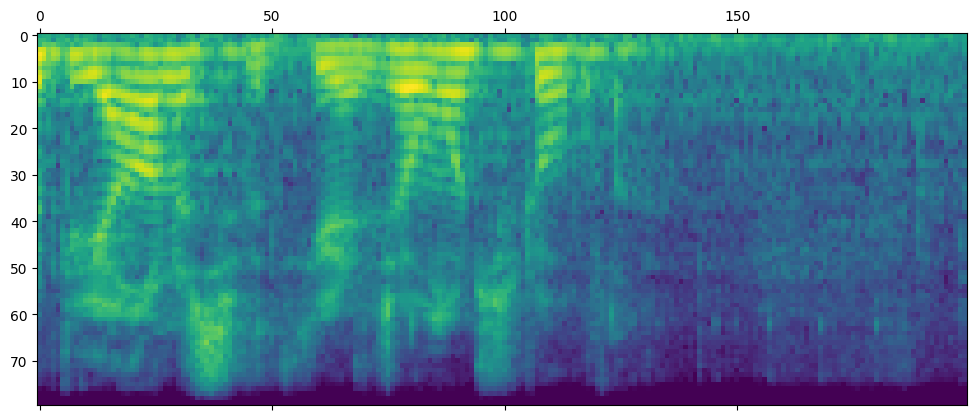

In [4]:
dev_dl = DALIGenericIterator(
    pipelines=[
        pipeline(
            urls=urls["Session5"],
            index_paths=indexes["Session5"],
            # urls=urls["development"],
            # index_paths=indexes["development"],
            random_shuffle=False,
            peak_normalize=True,
            preemphasis=False,
            max_duration=max_duration,
            hop_length=hop_length,
            num_mel=num_mel,
            augmentations=[],
            batch_size=batch_size,
            num_threads=16,
            device_id=dali_device,
        )
    ],
    output_map=["mel", "num_frames", "emodim", "emo"],
    reader_name="webdataset",
    auto_reset=False,
)
dev_batch = dev_dl._first_batch[0]
plt.matshow(dev_batch["mel"].cpu()[1])

In [5]:
# mel, view, num_frames, emodim, emo = pipe.run()

In [6]:
# plt.matshow(mel.as_cpu()[3])

In [7]:
# plt.matshow(view.as_cpu()[3])

In [8]:
# benchmark_pipeline(pipe)

In [9]:
from model import Classifier

/home/kd2939/dev/miniconda3/envs/emo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model = Classifier(
    pretrained_model_name_or_path="openai/whisper-small.en",
    max_duration=max_duration,
    projection_dim=128,
    num_classes=len(EMOTIONS) + 1,
).to(model_device)
cross_entropy_criterion = nn.CrossEntropyLoss().to(model_device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)
grad_scaler = torch.cuda.amp.GradScaler()

In [11]:
def train(
    model: nn.Module,
    dataloader: DALIGenericIterator,
    criterion,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
    grad_scaler: torch.cuda.amp.GradScaler,
    forward_pass_iters: int,
    grad_accum_iters: int,
    grad_norm: float,
    num_epochs: int,
    print_every: int,
    max_frames: int,
    feat_key: str,
):
    model.train()
    device = model.device
    epoch_losses = []
    for epoch_ix in range(num_epochs):
        with tqdm(total=len(dataloader)) as pbar:
            tot_epoch_loss = torch.tensor(0.0).to(device)
            batch_idx = 0
            for batches in dataloader:
                for batch in batches:
                    batch["emo"][batch["emo"] > len(EMOTIONS)] = len(EMOTIONS)
                    # FORWARD PASS
                    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                        feats = batch[feat_key].to(device)
                        attention_mask = num_frames_to_attention_mask(
                            num_frames=batch["num_frames"], max_frames=max_frames
                        ).to(device)
                        labels = batch["emo"].to(device)
                        out = model(feats, attention_mask)
                        loss = criterion(out, labels)

                    # BACKWARD PASS
                    grad_scaler.scale(loss).backward()

                    # GRADIENT UPDATE
                    if (batch_idx + 1) % grad_accum_iters == 0:
                        if grad_norm is not None:
                            grad_scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(
                                model.parameters(), max_norm=grad_norm
                            )
                        grad_scaler.step(optimizer)
                        grad_scaler.update()
                        optimizer.zero_grad()

                    # PBAR UPDATE
                    with torch.no_grad():
                        tot_epoch_loss += loss
                    if ((batch_idx + 1) % print_every) == 0:
                        pbar.set_description(
                            f"train_loss: {tot_epoch_loss.cpu().item() / batch_idx:.2f}"
                        )
                    batch_idx += 1
                pbar.update(1)
            # FINAL PBAR UPDATE
            tot_epoch_loss = tot_epoch_loss.cpu().item() / batch_idx
            pbar.set_description(f"train_loss: {tot_epoch_loss:.2f}")
        epoch_losses.append(tot_epoch_loss)

        # LR SCHEDULER
        if lr_scheduler is not None:
            lr_scheduler.step()
    return epoch_losses

In [12]:
def validate(
    model: nn.Module,
    dataloader: DALIGenericIterator,
    criterion,
    forward_pass_iters: int,
    print_every: int,
    target_names: list[str],
    max_frames: int,
    feat_key: str,
):
    model.eval()
    device = model.device
    batch_idx = 0
    with tqdm(total=len(dataloader)) as pbar:
        tot_epoch_loss = torch.tensor(0.0).cuda()
        preds = []
        truth = []
        for batches in dataloader:
            for batch in batches:
                batch["emo"][batch["emo"] > len(EMOTIONS)] = len(EMOTIONS)
                truth.append(batch["emo"])
                # FORWARD PASS
                with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                    feats = batch[feat_key].to(device)
                    attention_mask = num_frames_to_attention_mask(
                        num_frames=batch["num_frames"], max_frames=max_frames
                    ).to(device)
                    labels = batch["emo"].to(device)
                    with torch.no_grad():
                        out = model(feats, attention_mask)
                        loss = criterion(out, labels)
                preds.append(out.argmax(-1).cpu())

                # PBAR UPDATE
                with torch.no_grad():
                    tot_epoch_loss += loss
                if ((batch_idx + 1) % print_every) == 0:
                    pbar.set_description(
                        f"dev_loss: {tot_epoch_loss.cpu().item() / batch_idx:.2f}"
                    )
                batch_idx += 1
            pbar.update(1)
        # FINAL PBAR UPDATE
        tot_epoch_loss = tot_epoch_loss.cpu().item() / batch_idx
        pbar.set_description(f"dev_loss: {tot_epoch_loss:.2f}")
    preds = torch.cat(preds).numpy()
    truth = torch.cat(truth).numpy()
    print(
        classification_report(
            y_true=truth,
            y_pred=preds,
            labels=list(range(len(target_names))),
            target_names=target_names,
            zero_division=0.0,
        )
    )
    classification_dict = classification_report(
        y_true=truth,
        y_pred=preds,
        labels=list(range(len(target_names))),
        target_names=target_names,
        zero_division=0.0,
        output_dict=True,
    )
    return tot_epoch_loss, classification_dict

In [13]:
def train_and_validate(
    model: nn.Module,
    train_dataloader: DALIGenericIterator,
    dev_dataloader: DALIGenericIterator,
    criterion,
    optimizer,
    lr_scheduler,
    grad_scaler: torch.cuda.amp.GradScaler,
    forward_pass_iters: int,
    grad_accum_iters: int,
    grad_norm: float,
    num_epochs: int,
    print_every: int,
    validate_every: int,
    target_names: list[str],
    max_frames: int,
    feat_key: str,
):
    train_losses = []
    dev_losses = []
    for epoch_ix in range(num_epochs):
        train_losses.append(
            (
                epoch_ix + 1,
                train(
                    model=model,
                    dataloader=train_dataloader,
                    criterion=criterion,
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    grad_scaler=grad_scaler,
                    forward_pass_iters=forward_pass_iters,
                    grad_accum_iters=grad_accum_iters,
                    grad_norm=grad_norm,
                    num_epochs=1,
                    print_every=print_every,
                    max_frames=max_frames,
                    feat_key=feat_key,
                )[0],
            )
        )
        if (epoch_ix + 1) % validate_every == 0:
            dev_losses.append(
                (
                    epoch_ix + 1,
                    validate(
                        model=model,
                        dataloader=dev_dataloader,
                        criterion=criterion,
                        forward_pass_iters=forward_pass_iters,
                        print_every=print_every,
                        target_names=target_names,
                        max_frames=max_frames,
                        feat_key=feat_key,
                    ),
                )
            )
    return train_losses, dev_losses

In [ ]:
train_losses, dev_losses = train_and_validate(
    model=model,
    train_dataloader=train_dl,
    dev_dataloader=dev_dl,
    criterion=cross_entropy_criterion,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    grad_scaler=grad_scaler,
    forward_pass_iters=1,
    grad_accum_iters=1,
    grad_norm=None,
    num_epochs=40,
    print_every=10,
    validate_every=1,
    target_names=EMOTIONS + ["other"],
    max_frames=max_frames,
    feat_key="mel",
)

dev_loss: 1.64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 116.39it/s]


              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       384
       happy       0.00      0.00      0.00       143
         sad       0.78      0.03      0.05       251
       angry       0.11      0.96      0.20       170
     fearful       0.00      0.00      0.00        10
   surprised       0.00      0.00      0.00        18
   disgusted       0.00      0.00      0.00         0
       other       0.45      0.27      0.33      1200

   micro avg       0.23      0.23      0.23      2176
   macro avg       0.17      0.16      0.07      2176
weighted avg       0.35      0.23      0.21      2176



dev_loss: 1.42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 105.38it/s]


              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       384
       happy       0.00      0.00      0.00       143
         sad       0.62      0.02      0.04       251
       angry       0.33      0.63      0.43       170
     fearful       0.00      0.00      0.00        10
   surprised       0.00      0.00      0.00        18
   disgusted       0.00      0.00      0.00         0
       other       0.54      0.83      0.66      1200

   micro avg       0.51      0.51      0.51      2176
   macro avg       0.19      0.19      0.14      2176
weighted avg       0.40      0.51      0.40      2176



dev_loss: 1.29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 108.47it/s]


              precision    recall  f1-score   support

     neutral       0.44      0.01      0.02       384
       happy       0.00      0.00      0.00       143
         sad       0.53      0.04      0.07       251
       angry       0.51      0.46      0.48       170
     fearful       0.00      0.00      0.00        10
   surprised       0.00      0.00      0.00        18
   disgusted       0.00      0.00      0.00         0
       other       0.56      0.93      0.70      1200

   micro avg       0.56      0.56      0.56      2176
   macro avg       0.26      0.18      0.16      2176
weighted avg       0.49      0.56      0.44      2176



dev_loss: 1.22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 107.72it/s]


              precision    recall  f1-score   support

     neutral       0.48      0.03      0.05       384
       happy       0.00      0.00      0.00       143
         sad       0.57      0.10      0.16       251
       angry       0.46      0.58      0.51       170
     fearful       0.00      0.00      0.00        10
   surprised       0.00      0.00      0.00        18
   disgusted       0.00      0.00      0.00         0
       other       0.56      0.89      0.69      1200

   micro avg       0.55      0.55      0.55      2176
   macro avg       0.26      0.20      0.18      2176
weighted avg       0.50      0.55      0.45      2176



dev_loss: 1.19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 107.87it/s]


              precision    recall  f1-score   support

     neutral       0.50      0.05      0.09       384
       happy       0.00      0.00      0.00       143
         sad       0.64      0.13      0.21       251
       angry       0.45      0.56      0.50       170
     fearful       0.00      0.00      0.00        10
   surprised       0.00      0.00      0.00        18
   disgusted       0.00      0.00      0.00         0
       other       0.57      0.90      0.70      1200

   micro avg       0.56      0.56      0.56      2176
   macro avg       0.27      0.20      0.19      2176
weighted avg       0.51      0.56      0.47      2176



dev_loss: 1.15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 110.51it/s]


              precision    recall  f1-score   support

     neutral       0.60      0.10      0.17       384
       happy       0.00      0.00      0.00       143
         sad       0.61      0.18      0.28       251
       angry       0.44      0.54      0.48       170
     fearful       0.00      0.00      0.00        10
   surprised       0.00      0.00      0.00        18
   disgusted       0.00      0.00      0.00         0
       other       0.58      0.88      0.70      1200

   micro avg       0.57      0.57      0.57      2176
   macro avg       0.28      0.21      0.20      2176
weighted avg       0.53      0.57      0.48      2176



dev_loss: 1.14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 114.32it/s]


              precision    recall  f1-score   support

     neutral       0.63      0.11      0.19       384
       happy       0.00      0.00      0.00       143
         sad       0.61      0.10      0.17       251
       angry       0.48      0.42      0.45       170
     fearful       0.00      0.00      0.00        10
   surprised       0.00      0.00      0.00        18
   disgusted       0.00      0.00      0.00         0
       other       0.57      0.92      0.70      1200

   micro avg       0.57      0.57      0.57      2176
   macro avg       0.29      0.19      0.19      2176
weighted avg       0.53      0.57      0.48      2176



dev_loss: 1.11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 113.51it/s]


              precision    recall  f1-score   support

     neutral       0.63      0.12      0.20       384
       happy       1.00      0.01      0.01       143
         sad       0.61      0.18      0.28       251
       angry       0.57      0.31      0.40       170
     fearful       0.00      0.00      0.00        10
   surprised       0.00      0.00      0.00        18
   disgusted       0.00      0.00      0.00         0
       other       0.58      0.93      0.71      1200

   micro avg       0.58      0.58      0.58      2176
   macro avg       0.42      0.19      0.20      2176
weighted avg       0.61      0.58      0.49      2176



dev_loss: 1.06: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 109.53it/s]


              precision    recall  f1-score   support

     neutral       0.58      0.16      0.25       384
       happy       1.00      0.01      0.03       143
         sad       0.58      0.30      0.40       251
       angry       0.68      0.31      0.43       170
     fearful       0.00      0.00      0.00        10
   surprised       0.14      0.06      0.08        18
   disgusted       0.00      0.00      0.00         0
       other       0.60      0.93      0.73      1200

   micro avg       0.60      0.60      0.60      2176
   macro avg       0.45      0.22      0.24      2176
weighted avg       0.62      0.60      0.53      2176



train_loss: 1.24:  12%|██████████████▎                                                                                                             | 57/492 [00:02<00:17, 24.62it/s]

In [22]:
_=validate(
    model,
    dataloader=dev_dl,
    criterion=cross_entropy_criterion,
    forward_pass_iters=1,
    print_every=10,
    target_names=EMOTIONS + ["other"],
    max_frames=max_frames,
    feat_key="mel",
)

dev_loss: 0.61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [00:04<00:00, 106.31it/s]


              precision    recall  f1-score   support

     neutral       0.87      0.51      0.64      1324
       happy       0.86      0.35      0.49       452
         sad       0.68      0.75      0.72       839
       angry       0.85      0.71      0.77       933
     fearful       0.94      0.50      0.65        30
   surprised       0.98      0.51      0.67        89
   disgusted       0.00      0.00      0.00         2
       other       0.75      0.92      0.83      4203

    accuracy                           0.77      7872
   macro avg       0.74      0.53      0.60      7872
weighted avg       0.79      0.77      0.76      7872



In [23]:
weights = model.cpu().state_dict()

In [26]:
torch.save(weights, f'./cpts/nb/supervised_{get_timestamp()}.pt')